In [36]:
import numpy as np
import math
import pandas as pd
from pandas import DataFrame
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import random
import sklearn
import seaborn as sns

In [3]:
#import data
df=pd.read_csv('/Users/JackRitian/Desktop/Reinforcement Learning Bond/datas/bond_backtest.csv')
df.fillna(method='ffill')
df = df.drop(columns='close_1')
df = df.set_index('date')
date_list = df.index.to_list()


#process data
df_prev_1d = df.shift(1)
past_n_days = 70 #for 14 weeks
rolling_means = df_prev_1d.rolling(past_n_days).mean().dropna()
rolling_stds = df_prev_1d.rolling(past_n_days).std().dropna()
df_prev_1d = df_prev_1d.drop(index = date_list[0:past_n_days])
df = df.drop(index = date_list[0:past_n_days])
diff_df = df-df_prev_1d
pct_chg_df = diff_df/df_prev_1d
obs_df = (df_prev_1d-rolling_means)/(3*rolling_stds)
BB14W_df = rolling_stds*4
print(obs_df)

              yield     close
date                         
2002/4/26 -0.574704  0.652289
2002/4/29 -1.106583  0.611608
2002/4/30 -0.503285  0.586702
2002/5/8  -0.523145  0.605257
2002/5/9  -0.476724  0.586990
...             ...       ...
2021/2/8   0.004051  0.199189
2021/2/9   0.109946  0.167569
2021/2/10  0.070326  0.236057
2021/2/18  0.143597  0.177335
2021/2/19  0.338972  0.047290

[4562 rows x 2 columns]


In [8]:
#set up training, validation, test sets
whole_set_years=['2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
first_cut = int(np.ceil(len(whole_set_years)*0.6))
second_cut = int(np.ceil(len(whole_set_years)*0.8))
training_years= whole_set_years[0:first_cut]
validation_years=whole_set_years[first_cut:second_cut]
test_years=whole_set_years[second_cut:]


#set up training data
training_date_list = obs_df.index.to_list()
first_cut = int(np.ceil(len(training_date_list)*0.6))
second_cut = int(np.ceil(len(training_date_list)*0.8))


training_dates = training_date_list[0:first_cut]
validation_dates = training_date_list[first_cut:second_cut]
test_dates = training_date_list[second_cut:]


def set_up_dateset(training_dates,obs_df,BB14W_df,diff_df,item):
    training_set_obs = obs_df[item][training_dates].to_list()
    training_set_BB14W = BB14W_df[item][training_dates].to_list()
    training_set_df = pd.DataFrame({'obs':training_set_obs,'BB14W':training_set_BB14W})
    training_set = training_set_df.to_numpy()
    training_set_diff = diff_df[item][training_dates].to_list()
    training_set_y = []
    for i in range(0,len(training_set_diff)):
        if training_set_diff[i] < 0:
            training_set_y.append(-1)
        else:
            training_set_y.append(1)

    print(len(training_set),len(training_set_y))
    return training_set, training_set_y, training_set_df


training_set, training_set_y, training_set_df = set_up_dateset(training_dates,obs_df,BB14W_df,diff_df,'yield')
validation_set, validation_set_y,  validation_set_df = set_up_dateset(validation_dates,obs_df,BB14W_df,diff_df,'yield')
test_set, test_set_y, test_set_df = set_up_dateset(test_dates,obs_df,BB14W_df,diff_df,'yield')

2738 2738
912 912
912 912


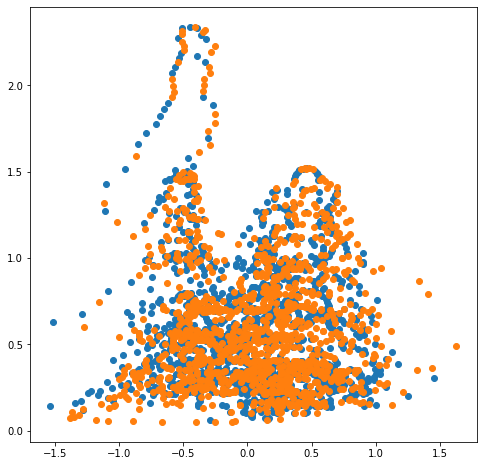

In [9]:
#check for distribution
x_up=[]
y_up=[]
x_down=[]
y_down=[]


for i in range(0,len(training_set_y)):
    if training_set_y[i] == 1:
        x_up.append(training_set[i][0])
        y_up.append(training_set[i][1])
    else:
        x_down.append(training_set[i][0])
        y_down.append(training_set[i][1])


plt.figure(figsize=(8, 8))
plt.scatter(x_up,y_up)
plt.scatter(x_down,y_down)
plt.show()

In [17]:
uni_obs = pd.qcut(training_set_df['obs'],q=np.linspace(0,1,16),labels=range(1,16))
uni_BB14W = pd.qcut(training_set_df['BB14W'],q=np.linspace(0,1,16),labels=range(1,16))

In [18]:
training_set_df.head()

,obs,BB14W
0,-0.574704,1.166942
1,-1.106583,1.272003
2,-0.503285,1.291242
3,-0.523145,1.291985
4,-0.476724,1.280335


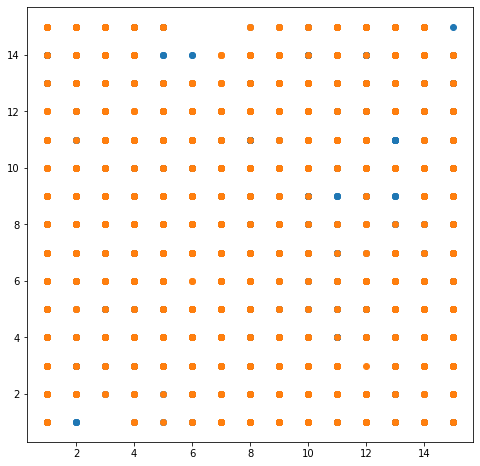

In [20]:
#check for distribution
x_up=[]
y_up=[]
x_down=[]
y_down=[]


for i in range(0,len(training_set_y)):
    if training_set_y[i] == 1:
        x_up.append(uni_obs[i])
        y_up.append(uni_BB14W[i])
    else:
        x_down.append(uni_obs[i])
        y_down.append(uni_BB14W[i])


plt.figure(figsize=(8, 8))
plt.scatter(x_down,y_down)
plt.scatter(x_up,y_up)
plt.show()

In [30]:
q_matrix = np.zeros([15,15])
for i in range(0,len(training_set_y)):
        q_matrix[uni_obs[i]-1,uni_BB14W[i]-1] = q_matrix[uni_obs[i]-1,uni_BB14W[i]-1] + training_set_y[i]

In [35]:
obs_list = []
BB14W_list = []
score_list = []

for i in range(0,15):
    for j in range(0,15):
        obs_list.append(i)
        BB14W_list.append(j)
        score_list.append(q_matrix[i,j])


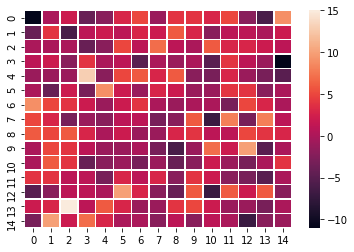

In [37]:
ax = sns.heatmap(q_matrix, linewidth=0.5)

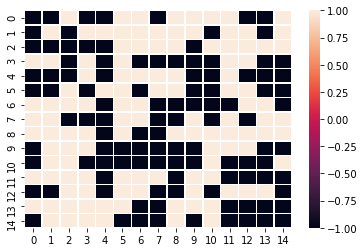

In [38]:
decision_matrix = np.zeros([15,15])

for i in range(0,15):
    for j in range(0,15):
        if q_matrix[i,j] > 0:
            decision_matrix[i,j] = 1
        else:
            decision_matrix[i,j] = -1

ax = sns.heatmap(decision_matrix, linewidth=0.5)

In [1]:
import torch